# Theory

In [20]:
import numpy as np

In [21]:
#t1 is the coordinate of object to camera
t1 = [[0, 1, 0, 1],
      [1, 0, 0, 10],
      [0, 0, -1, 9],
      [0, 0, 0, 1]]

#t2 is the coordinate of robot base to camera
t2 = [[1, 0, 0, -10],
      [0, -1, 0, 20],
      [0, 0, -1, 10],
      [0, 0, 0, 1]]

#rotation matrix of 90 degree around z-axis of the camera
Rz = [[0, -1, 0, 0],
      [1, 0, 0, 0],
      [0, 0, 1, 0],
      [0, 0, 0, 1]]

#rotation matrix of 90 degree around x-axis of the object
Rx = [[1, 0, 0, 0],
      [0, 0, -1, 0],
      [0, 1, 0, 0],
      [0, 0, 0, 1]]

#translation matrix by 4 unit along the y axis
T  = [[1, 0, 0, 0],
      [0, 1, 0, 4],
      [0, 0, 1, 0],
      [0, 0, 0, 1]]

Question a): After the equipment has been setup and these coordinate systems have been established, someone rotated the camera 90 degree about the z axis of the camera. What is the position and orientation of the camera with respect to the robot’s base coordinate system?

In [22]:
#invert t2 to get the coordinate of the camera with respect to the robot base
t2_invert = np.linalg.inv(t2)
t2_invert

array([[ 1.,  0.,  0., 10.],
       [-0., -1., -0., 20.],
       [-0., -0., -1., 10.],
       [ 0.,  0.,  0.,  1.]])

In [23]:
#the new position and orientation of the camera with respect to the robot base = t2_invert * Rz
rot_cam_to_base = np.matmul(t2_invert,Rz)

for r in rot_cam_to_base:
    print(r)

[ 0. -1.  0. 10.]
[-1.  0.  0. 20.]
[ 0.  0. -1. 10.]
[0. 0. 0. 1.]


Question b) After the rotation happened in a), the object is also rotated by 90 degree about the x axis of the object and translated by 4 units along the rotated y axis. What is the position and orientation of the object with respect to the robot’s base coordinate system? What is the position and orientation of the object with respect to the rotated camera coordinate system?

In [24]:
#the position and orientation of the object with respect to the robot base after rotated
obj_to_base = np.matmul(t2_invert,t1)
rot_obj_to_base = np.matmul(obj_to_base,Rx)
final_obj_to_base = np.matmul(rot_obj_to_base, T)
final_obj_to_base

array([[ 0.,  0., -1., 11.],
       [-1.,  0.,  0., 10.],
       [ 0.,  1.,  0.,  5.],
       [ 0.,  0.,  0.,  1.]])

In [25]:
#the position and orientation of the rotated object with respect to the rotated camera
rot_obj_to_rot_cam = np.matmul(np.linalg.inv(t2), final_obj_to_base)
rot_obj_to_rot_cam

array([[ 0.,  0., -1., 21.],
       [ 1.,  0.,  0., 10.],
       [ 0., -1.,  0.,  5.],
       [ 0.,  0.,  0.,  1.]])

# Programming

# Task 1

In [66]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import glob
import yaml

def calibrate(folder, CHESSBOARD_CORNER_NUM_X, CHESSBOARD_CORNER_NUM_Y, criteria ):
    CAMERA_PARAMETERS_OUTPUT_FILE = "cam.yaml"
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
    objp = np.zeros((CHESSBOARD_CORNER_NUM_X*CHESSBOARD_CORNER_NUM_Y,3), np.float32)
    objp[:,:2] = np.mgrid[0:CHESSBOARD_CORNER_NUM_X,0:CHESSBOARD_CORNER_NUM_Y].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob(folder)
    for fname in images:
        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)

        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners2)
            # Draw and display the corners
            cv.drawChessboardCorners(img, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), corners2, ret)
        else:
            print('Failed to find a chessboard in {}'.format(fname))
    
    # Draw lines to check distortion
    draw_line(img, corners)
    
    #get the camera matrix
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    print("Camera matrix is \n", mtx, "\n And is stored in calibration.yaml file along with distortion coefficients : \n", dist)
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
        mean_error += error
    print( "total error: {}".format(mean_error/len(objpoints)) )
    data = {'camera_matrix': np.asarray(mtx).tolist(), 'dist_coeff': np.asarray(dist).tolist()}
    with open(CAMERA_PARAMETERS_OUTPUT_FILE, "w") as f:
        yaml.dump(data, f)
        
    return mtx, dist

In [67]:
#undistort an image
def undistort(img, mtx, dist):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    dst = cv.undistort(img, mtx, dist, None, newcameramtx)
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    cv.imwrite('undistort.png', dst)
    plt.subplot(121)
    plt.imshow(img)
    plt.title('distorted')
    plt.subplot(122)
    plt.imshow(dst)
    plt.title('undistorted')

In [68]:
def draw_line(img, corners):
    # Draw lines to check distortion
    cv.line(img, tuple(map(int, corners[0, 0])), tuple(map(int, corners[45, 0])), (0, 0, 255), 1)
    cv.line(img, tuple(map(int, corners[8, 0])), tuple(map(int, corners[53, 0])), (0, 0, 255), 1)
    cv.line(img, tuple(map(int, corners[0, 0])), tuple(map(int, corners[8, 0])), (0, 0, 255), 1)
    cv.line(img, tuple(map(int, corners[45, 0])), tuple(map(int, corners[53, 0])), (0, 0, 255), 1)
    plt.imshow(img);

In [69]:
CHESSBOARD_CORNER_NUM_X = 9
CHESSBOARD_CORNER_NUM_Y = 6

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

Camera matrix is 
 [[381.04637168   0.         327.53223633]
 [  0.         383.92439962 281.01408327]
 [  0.           0.           1.        ]] 
 And is stored in calibration.yaml file along with distortion coefficients : 
 [[-0.40946471  0.20850606  0.00500679  0.0019875  -0.04237025]]
total error: 0.04871493265213206


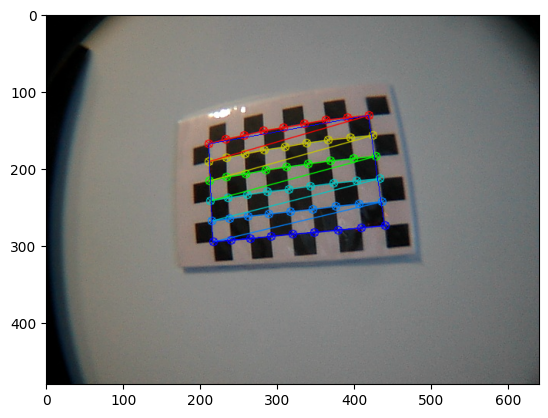

In [70]:
folder = './cam2_images/*.jpg'
mtx, dist = calibrate(folder, CHESSBOARD_CORNER_NUM_X, CHESSBOARD_CORNER_NUM_Y, criteria )

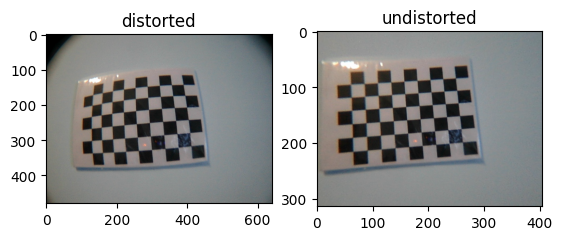

In [71]:
img = cv.imread('cam2_images/11.jpg')
undistort(img, mtx, dist)

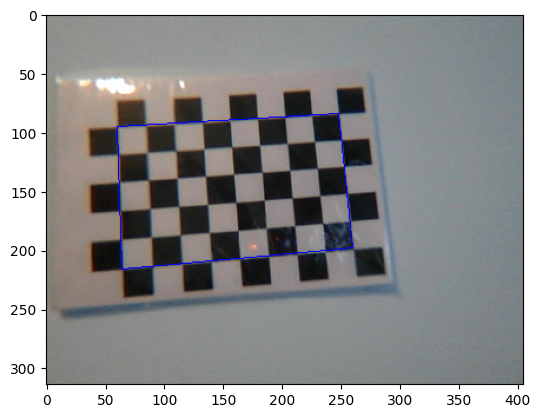

In [72]:
und = cv.imread('undistort.png')
undistort_gray = cv.cvtColor(und, cv.COLOR_BGR2GRAY)
# Find the chess board corners
ret_undistort, corners_undistort = cv.findChessboardCorners(undistort_gray, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)

#find corners
corners_undistort = cv.cornerSubPix(undistort_gray,corners_undistort, (11,11), (-1,-1), criteria)

draw_line(und,corners_undistort)